How data balancing methods affect model quality?

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

train_dir = Path('./data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('./data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('./data/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [7]:
def paths_to_dataframe(path):
    labels = []
    for i in range(len(path)):
        labels.append(str(path[i]).split(os.sep)[-2])

    labels = pd.Series(labels, name='Label')
    path = pd.Series(path, name='Path').astype(str)

    df = pd.concat([path, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df
    
train_df = paths_to_dataframe(train_filepaths)
test_df = paths_to_dataframe(test_filepaths)
val_df = paths_to_dataframe(val_filepaths)

test_df.head()
print()

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    classification_rep = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(classification_rep)

    classes = np.unique(y_test)
    class_accuracy = {}
    for cls in classes:
        indices = np.where(y_test == cls)[0]
        class_accuracy[cls] = accuracy_score(y_test[indices], np.array(y_pred)[indices])

    return accuracy, precision, recall, f1, class_accuracy

In [9]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

y_test = test_df['Label']
y_train = train_df['Label']

In [10]:
from sklearn.tree import DecisionTreeClassifier

def nested_dichotomy(X_train, y_train, X_test, balancer):
    unique_labels = np.unique(y_train)
    num_classes = len(unique_labels)
    classifiers = []
    classified_indices = np.full(len(X_train), False)

    for i in unique_labels:
        y_binary = np.where(y_train == i, 1, 0)
        tree = DecisionTreeClassifier()

        X_train_balanced, y_train_balanced = balancer.fit_resample(X_train, y_binary)

        tree.fit(X_train_balanced, y_train_balanced)
        classifiers.append((tree, i))
        print(i)

    predictions = []
    for tree, positive_label in classifiers:
        binary_prediction = tree.predict(X_test)
        predictions.append(np.where(binary_prediction == 1, positive_label, None))

    results = ['tomato' for _ in range(len(X_test))]
    for i in range(len(predictions)):
        for j in range(len(X_test)):
            if predictions[i][j] is not None:
                results[j] = unique_labels[i]
        

    return results, predictions, classifiers

In [11]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tensorflow.keras.applications import MobileNetV2

balancers = (RandomOverSampler(random_state=42), SMOTE(random_state=42), 
            RandomUnderSampler(random_state=42), TomekLinks(), SMOTETomek(random_state=42))

mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
X_train = np.array([extract_features(img_path, mobilenet_model) for img_path in train_df['Path']])
X_test = np.array([extract_features(img_path, mobilenet_model) for img_path in test_df['Path']])

models_dict = {}

for balancer in balancers:
    print(str(balancer))
    results, pred, models = nested_dichotomy(X_train, y_train, X_test, balancer)
    accuracy, precision, recall, f1, class_accuracy = metrics(y_test, results)

    models_dict[str(balancer)] = (results, pred, models, accuracy, precision, recall, f1, class_accuracy)

/var/folders/kb/21stffp561n7vlhn9h_r55zc0000gn/T/ipykernel_48078/3079305310.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

/Users/tomasz/Projects/Projekty PWr/uczenie_maszynowe/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tomasz/Projects/Projekty PWr/uczenie_maszynowe/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tomasz/Projects/Projekty PWr/uczenie_maszynowe/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

apple
banana
beetroot
bell pepper
cabbage
capsicum
carrot
cauliflower
chilli pepper
corn
cucumber
eggplant
garlic
ginger
grapes
jalepeno
kiwi
lemon
lettuce
mango
onion
orange
paprika
pear
peas
pineapple
pomegranate
potato
raddish
soy beans
spinach
sweetcorn
sweetpotato
tomato
turnip
watermelon
Accuracy:  0.9520958083832335
Precision:  0.9643001875037803
Recall:  0.9520958083832335
F1:  0.9534596073958526
Classification Report:
               precision    recall  f1-score   support

        apple       1.00      0.67      0.80         9
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.89      0.94         9
      cabbage       0.91      1.00      0.95        10
     capsicum       0.89      0.89      0.89         9
       carrot       0.88      1.00      0.93         7
  cauliflower       1.00      1.00      1.00         9
chilli pepper       1.00      1.00      1.00         7
         corn     

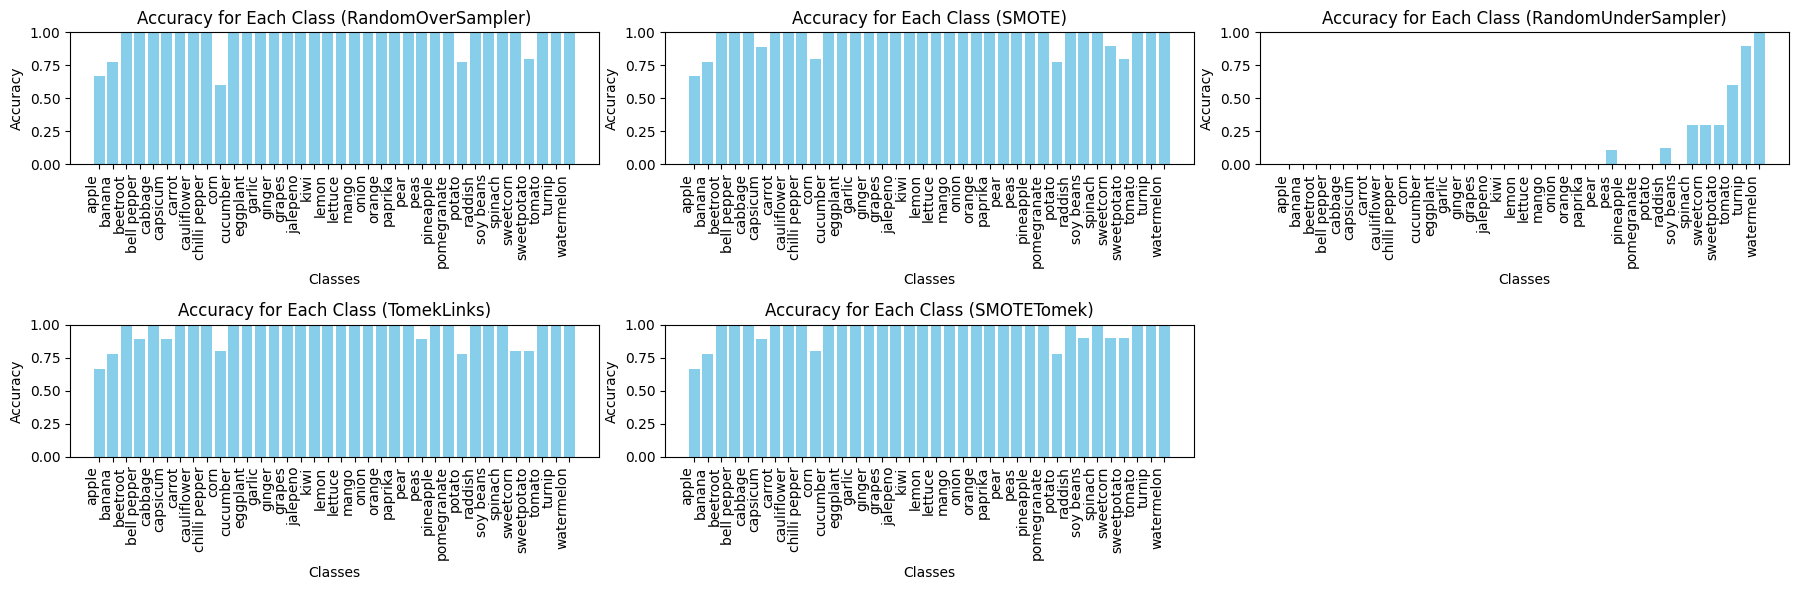

In [21]:
models_dict[str(balancer)] = (results, pred, models, accuracy, precision, recall, f1, class_accuracy)

plt.figure(figsize=(18, 6))

rand_over_res = models_dict['RandomOverSampler(random_state=42)'][7] ## class_accuracy
plt.subplot(2, 3, 1)
plt.bar(rand_over_res.keys(), rand_over_res.values(), color='skyblue')
plt.title('Accuracy for Each Class (RandomOverSampler)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

smote_res = models_dict['SMOTE(random_state=42)'][7] ## class_accuracy
plt.subplot(2, 3, 2)
plt.bar(smote_res.keys(), smote_res.values(), color='skyblue')
plt.title('Accuracy for Each Class (SMOTE)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

rand_under_res = models_dict['RandomUnderSampler(random_state=42)'][7] ## class_accuracy
plt.subplot(2, 3, 3)
plt.bar(rand_under_res.keys(), rand_under_res.values(), color='skyblue')
plt.title('Accuracy for Each Class (RandomUnderSampler)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

tomek_res = models_dict['TomekLinks()'][7] ## class_accuracy
plt.subplot(2, 3, 4)
plt.bar(tomek_res.keys(), tomek_res.values(), color='skyblue')
plt.title('Accuracy for Each Class (TomekLinks)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

smotetomek_res = models_dict['SMOTETomek(random_state=42)'][7] ## class_accuracy
plt.subplot(2, 3, 5)
plt.bar(smotetomek_res.keys(), smotetomek_res.values(), color='skyblue')
plt.title('Accuracy for Each Class (SMOTETomek)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

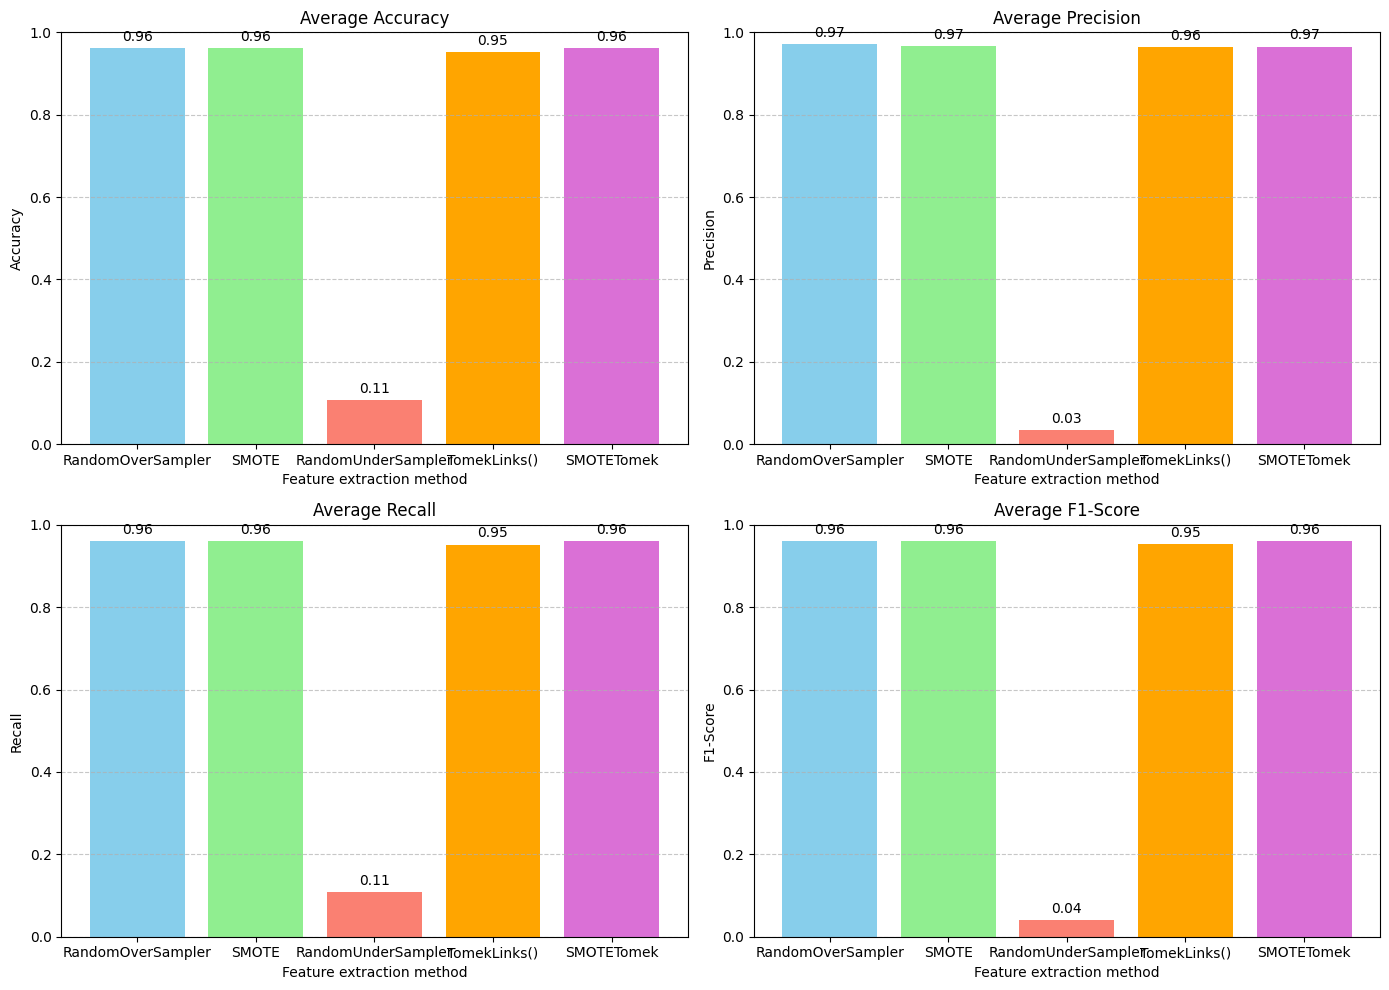

In [43]:
methods = ['RandomOverSampler', 'SMOTE', 'RandomUnderSampler', 'TomekLinks()', 'SMOTETomek']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'orchid']

rand_over_res = models_dict['RandomOverSampler(random_state=42)']
smote_res = models_dict['SMOTE(random_state=42)']
rand_under_res = models_dict['RandomUnderSampler(random_state=42)']
tomek_res = models_dict['TomekLinks()']
smotetomek_res = models_dict['SMOTETomek(random_state=42)']

metrics_data = {
    'Accuracy': [rand_over_res[3], smote_res[3], rand_under_res[3], tomek_res[3], smotetomek_res[3]],
    'Precision': [rand_over_res[4], smote_res[4], rand_under_res[4], tomek_res[4], smotetomek_res[4]],
    'Recall': [rand_over_res[5], smote_res[5], rand_under_res[5], tomek_res[5], smotetomek_res[5]],
    'F1-Score': [rand_over_res[6], smote_res[6], rand_under_res[6], tomek_res[6], smotetomek_res[6]]
}

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, i+1)
    bars = plt.bar(methods, metrics_data[metric], color=colors)
    plt.title('Average ' + metric)
    plt.xlabel('Feature extraction method')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [35]:
df = pd.DataFrame(metrics_data, index=methods)
print("Metrics Data:")
print(df)

Metrics Data:
                    Accuracy  Precision    Recall  F1-Score
RandomOverSampler   0.961078   0.970578  0.961078  0.960382
SMOTE               0.961078   0.966289  0.961078  0.960491
RandomUnderSampler  0.107784   0.033772  0.107784  0.041136
TomekLinks()        0.952096   0.964300  0.952096  0.953460
SMOTETomek          0.961078   0.965212  0.961078  0.960165
